# Feature Engineering with in house software

In this notebook, we will set up all the feature engineering steps within a Scikit-learn pipeline utilizing the open source transformers plus those we developed in house.

Then, we will add the scaler, the feature selection class and the Lasso.

# Reproducibility: Setting the seed

With the aim to ensure reproducibility between runs of the same notebook, but also between the research and production environment, for each step that includes some element of randomness, it is extremely important that we **set the seed**.

In [1]:
# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import preprocessors as pp

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [2]:
# load dataset
data = pd.read_csv('houseprice.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Cast MSSubClass as object

data['MSSubClass'] = data['MSSubClass'].astype('O')

# Separate dataset into train and test

It is important to separate our data intro training and testing set. 

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

Our feature engineering techniques will learn:

- mean
- mode
- exponents for the yeo-johnson
- category frequency
- and category to number mappings

from the train set.

**Separating the data into train and test involves randomness, therefore, we need to set the seed.**

In [4]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1), # predictive variables
    data['SalePrice'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

# Target

We apply the logarithm

In [5]:
y_train = np.log(y_train)
y_test = np.log(y_test)

# Config

In [6]:
# categorical variables with NA in train set
CATEGORICAL_VARS_WITH_NA_FREQUENT = ['MasVnrType',
                                     'BsmtQual',
                                     'BsmtCond',
                                     'BsmtExposure',
                                     'BsmtFinType1',
                                     'BsmtFinType2',
                                     'Electrical',
                                     'GarageType',
                                     'GarageFinish',
                                     'GarageQual',
                                     'GarageCond']


CATEGORICAL_VARS_WITH_NA_MISSING = [
    'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


# numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


TEMPORAL_VARS = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
REF_VAR = "YrSold"

# this variable is to calculate the temporal variable,
# can be dropped afterwards
DROP_FEATURES = ["YrSold"]

# variables to log transform
NUMERICALS_LOG_VARS = ["LotFrontage", "1stFlrSF", "GrLivArea"]

NUMERICALS_YEO_VARS = ['LotArea']


BINARIZE_VARS = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

# variables to map
QUAL_VARS = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
             ]

EXPOSURE_VARS = ['BsmtExposure']

FINISH_VARS = ['BsmtFinType1', 'BsmtFinType2']

GARAGE_VARS = ['GarageFinish']

FENCE_VARS = ['Fence']

# categorical variables to encode
CATEGORICAL_VARS = [
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating',
    'CentralAir',
    'Electrical',
    'Functional',
    'GarageType',
    'PavedDrive',
    'PoolQC',
    'MiscFeature',
    'SaleType',
    'SaleCondition',
    'MSSubClass']


QUAL_MAPPINGS = {'Po': 1, 'Fa': 2, 'TA': 3,
                 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

EXPOSURE_MAPPINGS = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

FINISH_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1,
                   'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

GARAGE_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

FENCE_MAPPINGS = {'Missing': 0, 'NA': 0,
                  'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

# Pipeline - End-to-end

In [7]:
# set up the pipeline
price_pipe = Pipeline([

    # ===== IMPUTATION =====
    # impute categorical variables with string missing
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING)),

    ('frequent_imputation', CategoricalImputer(
        imputation_method='frequent', variables=CATEGORICAL_VARS_WITH_NA_FREQUENT)),

    # add missing indicator
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),

    # impute numerical variables with the mean
    ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA
    )),
    
    
    # == TEMPORAL VARIABLES ====
    ('elapsed_time', pp.TemporalVariableEstimator(
        variables=TEMPORAL_VARS, reference_variable=REF_VAR)),

    ('drop_features', DropFeatures(features_to_drop=DROP_FEATURES)),

   

    # ==== VARIABLE TRANSFORMATION =====
    ('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),
    
    ('yeojohnson', YeoJohnsonTransformer(variables=NUMERICALS_YEO_VARS)),
    
    ('binarizer', SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=BINARIZE_VARS)),
    

    # === mappers ===
    ('mapper_qual', pp.Mapper(
        variables=QUAL_VARS, mappings=QUAL_MAPPINGS)),

    ('mapper_exposure', pp.Mapper(
        variables=EXPOSURE_VARS, mappings=EXPOSURE_MAPPINGS)),

    ('mapper_finish', pp.Mapper(
        variables=FINISH_VARS, mappings=FINISH_MAPPINGS)),

    ('mapper_garage', pp.Mapper(
        variables=GARAGE_VARS, mappings=GARAGE_MAPPINGS)),
    
    ('mapper_fence', pp.Mapper(
        variables=FENCE_VARS, mappings=FENCE_MAPPINGS)),


    # == CATEGORICAL ENCODING
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.01, n_categories=1, variables=CATEGORICAL_VARS
    )),

    # encode categorical and discrete variables using the target mean
    ('categorical_encoder', OrdinalEncoder(
        encoding_method='ordered', variables=CATEGORICAL_VARS)),
    
    
    ('scaler', MinMaxScaler()),
    ('selector', SelectFromModel(Lasso(alpha=0.001, random_state=0))),
    ('Lasso', Lasso(alpha=0.002, random_state=0)),
])

In [8]:
# train the pipeline
price_pipe.fit(X_train, y_train)

C:\Users\Sole\Documents\Repositories\envs\feml\lib\site-packages\scipy\stats\morestats.py:1476: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
C:\Users\Sole\Documents\Repositories\envs\feml\lib\site-packages\scipy\optimize\optimize.py:2555: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\Sole\Documents\Repositories\envs\feml\lib\site-packages\scipy\optimize\optimize.py:2148: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\Sole\Documents\Repositories\envs\feml\lib\site-packages\scipy\optimize\optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['Alley', 'FireplaceQu', 'PoolQC',
                                               'Fence', 'MiscFeature'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['MasVnrType', 'BsmtQual',
                                               'BsmtCond', 'BsmtExposure',
                                               'BsmtFinType1', 'BsmtFinType2',
                                               'Electrical', 'GarageType',
                                               'GarageFinish', 'GarageQual',
                                               'GarageCon...
                                           'RoofStyle', 'RoofMatl',
                                           'Exterior1st', 'Exterior2nd',
                                           'MasVnrType', 'Foundation',
                                           'Heat

In [9]:
# evaluate the model:
# ====================

# make predictions for train set
pred = price_pipe.predict(X_train)

# determine mse, rmse and r2
print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# make predictions for test set
pred = price_pipe.predict(X_test)

# determine mse, rmse and r2
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

print('Average house price: ', int(np.exp(y_train).median()))

train mse: 832474061
train rmse: 28852
train r2: 0.8666725693461033

test mse: 1151199760
test rmse: 33929
test r2: 0.8324824725794973

Average house price:  163000


Identical results to when we did all the engineering manually.

Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

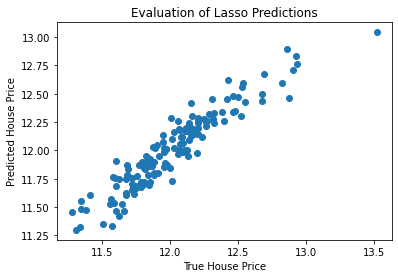

In [10]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, price_pipe.predict(X_test))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Lasso Predictions')

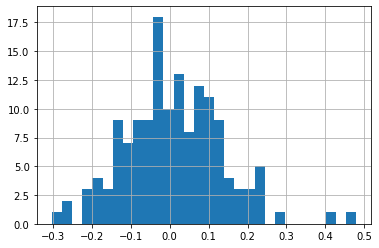

In [12]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(price_pipe.predict(X_test))

errors = y_test - preds
errors.hist(bins=30)
plt.show()

# Conclusion

Now we have and end to end Pipeline, that takes in some data, and then outputs House Sale Prices predictions.

The only extra bit that would be useful, is to reduce the amount of feature engineering to only those variables that will actually be used to train the notebook.